This project is to predict if a customer is happy or not based on the survey answers.

**Data Description:**

- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
- X1 = my order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted to order
- X4 = I paid a good price for my order 
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me 

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer. 

# Table of contents

 - [EDA](#eda)
   - [1. Check missing values](#nan)
   - [2. Check duplicates](#dup)
   - [3. Check class ratio](#classratio)
   - [4. Rename columns](#rename)
   - [5. Check outliers](#outliers)
   - [6. Check multicollinearity](#multicollinearity)
 - [Feature Selection](#fs)
   - [1. Feature Importance](#fi)
   - [2. Univariate Feature Selection](#ufs)
 - [Data Split](#datasplit)
 - [Modelling](#model)
   - [1. Logistic Regression](#logit)
   - [2. Decision Tree](#dt)
   - [3. Random Forest](#rf)
   - [4. XGB](#xgb)
 - [Conclusion](#conclusion)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv('ACME-HappinessSurvey2020.csv')
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [3]:
print(f' This dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

 This dataset has 126 rows and 7 columns.


# EDA <a class="anchor" id="eda"></a>

In [4]:
# check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


### 1. Check missing values <a class="anchor" id="nan"></a>

In [5]:
df.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

### 2. Check duplicates <a class="anchor" id="dup"></a>

In [6]:
# check duplicated rows
df.duplicated().sum()

16

In [7]:
# percentage of duplicates
df.duplicated().sum()/df.shape[0]*100

12.698412698412698

In [8]:
# check duplicated columns
df.T.duplicated().sum()

0

We see there is no missing values but approximately **13%** of the dataset is duplicate on the row-level. Let's investigate further using the index returned.

In [9]:
# look at duplicated rows
df[df.duplicated(keep=False)]

,Y,X1,X2,X3,X4,X5,X6
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
7,1,5,4,4,4,4,5
19,0,4,2,4,4,4,4
21,0,4,3,5,5,5,4
22,0,4,3,5,5,5,4
27,1,3,3,1,3,3,4
28,1,3,3,1,3,3,4
32,1,3,2,4,4,4,5
33,1,3,2,4,4,4,5


Because there are limited (6) features and no unique identifier, it is possible that the duplicate rows do describe different customers with the same answers. However, given that the shape of dataset is small, we will assume that this is likely, and that these rows are in fact given by different customers, therefore we will keep it as is.

### 3. Check class ratio <a class="anchor" id="classratio"></a>

In [10]:
X=df.loc[:,df.columns!='Y']  # or X=df.drop(columns='Y')
y=df['Y']

In [11]:
X.head()

,X1,X2,X3,X4,X5,X6
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5


In [12]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Y, dtype: int64

In [13]:
# check class ratio
y.value_counts(normalize=True)

1    0.547619
0    0.452381
Name: Y, dtype: float64

The dataset is pretty balanced in terms of class ratio.

### 4. Rename columns <a class="anchor" id="rename"></a>

- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
- X1 = my order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted to order
- X4 = I paid a good price for my order 
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me 

Given the meaning of the features, I changed the column names for the purpose of interpretability.

In [14]:
X.columns=['on-time_delivery','correct_order_contents','availability','good_price','courier_satisfaction','easy_order']
X.head()

,on-time_delivery,correct_order_contents,availability,good_price,courier_satisfaction,easy_order
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5


### 5. Check outliers <a class="anchor" id="outliers"></a>

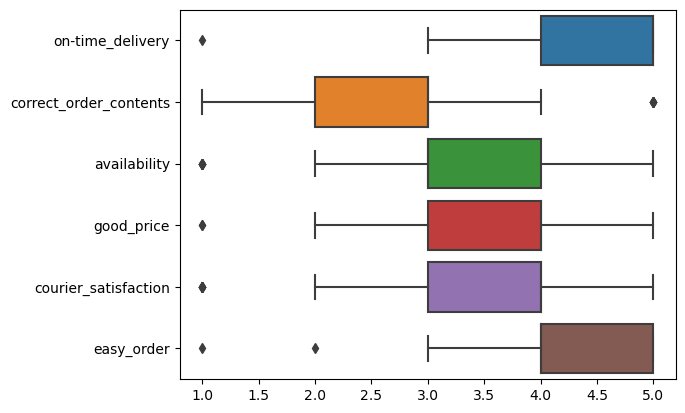

In [15]:
sns.boxplot(data=X, orient="h");

The number of outliers is not significant, so no action is required.

### 6. Check multicollinearity <a class="anchor" id="multicollinearity"></a>


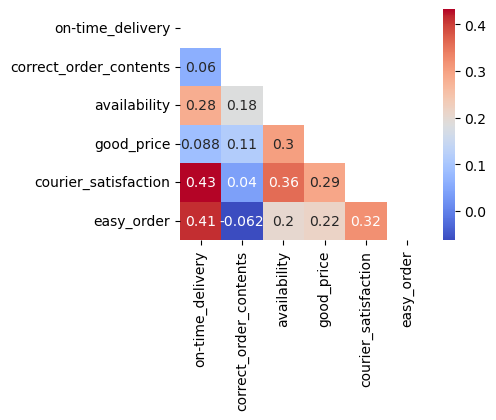

In [16]:
# heatmap of correlation
plt.figure(figsize=(4,3))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

We see no multicollinearity between the variables.
> Overall, we can see that this dataset is clean and ready for modelling.

# Data Split <a class="anchor" id="datasplit"></a>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [18]:
X_train.shape

(100, 6)

In [19]:
X_test.shape

(26, 6)

# Feature Selection <a class="anchor" id="fs"></a>

### 1. Feature Importance <a class="anchor" id="fi"></a>

In [20]:
# Instantiate and fit RandomForestClassifier
random_forest=RandomForestClassifier(random_state=666)
random_forest.fit(X_train,y_train)

# Get feature importances
feature_importance=pd.DataFrame({'Feature importance':random_forest.feature_importances_},index=X_train.columns)
feature_importance.sort_values(by=['Feature importance'],ascending=False)

,Feature importance
availability,0.207126
courier_satisfaction,0.192107
correct_order_contents,0.186031
good_price,0.158710
on-time_delivery,0.155964
easy_order,0.100063


### 2. Univariate Feature Selection <a class="anchor" id="ufs"></a>

In [21]:
# instantiate and fit
my_KBest = SelectKBest(score_func=chi2, k='all').fit(X_train, y_train)

# put result into a dataframe
KBest_result=pd.DataFrame({'Scores':my_KBest.scores_},index=X_train.columns)
KBest_result.sort_values(by=['Scores'],ascending=False)

,Scores
courier_satisfaction,2.526876
availability,1.789803
on-time_delivery,0.784357
good_price,0.688312
easy_order,0.319337
correct_order_contents,0.041045


It is of note that `courier_satisfaction` and `availability` score significantly higher Chi2 value than others. 

Now let's look at how different K works.

In [22]:
train_score = []
test_score = []

ks = list(range(1,7))

for i in ks: 
    # fit SelectKBest to train data to return a f_regression score per K value. 
    my_KBest = SelectKBest(score_func=chi2,k=i).fit(X_train, y_train)
    
    # Applying the above to the train and test data
    X_train_selected = my_KBest.transform(X_train)
    X_test_selected = my_KBest.transform(X_test)
    
    #Run the above on a decision tree model
    model = DecisionTreeClassifier(random_state=67)
    model.fit(X_train_selected, y_train)
    
    #Add print statement
    print(f"k = {i}, {np.array(X_train.columns)[my_KBest.get_support()]}")
    
#Score the model
    train_score.append(model.score(X_train_selected, y_train))
    test_score.append(model.score(X_test_selected, y_test))

k = 1, ['courier_satisfaction']
k = 2, ['availability' 'courier_satisfaction']
k = 3, ['on-time_delivery' 'availability' 'courier_satisfaction']
k = 4, ['on-time_delivery' 'availability' 'good_price' 'courier_satisfaction']
k = 5, ['on-time_delivery' 'availability' 'good_price' 'courier_satisfaction'
 'easy_order']
k = 6, ['on-time_delivery' 'correct_order_contents' 'availability' 'good_price'
 'courier_satisfaction' 'easy_order']


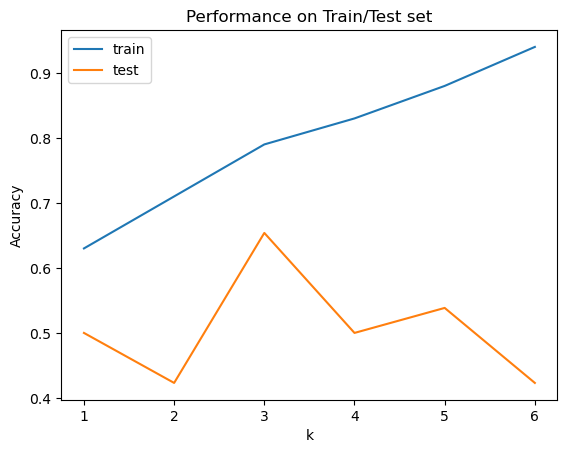

In [23]:
#plot the model
plt.figure()
plt.plot(ks, train_score, label="train")
plt.plot(ks, test_score, label="test")
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Performance on Train/Test set")
plt.legend()
plt.show()

We see **k=3** possibly gives the highest test accuracy. However, a closer look at all the features, we notice that there are only 2 features that are relevant to us - a logistics company, namely `courier_satisfaction` and `on-time_delivery` while the other four are related to our partners, from whom we receive packages to deliver to the customers. Hence, due to many possibilities, I would suggest modelling 3 sets of features:

- Set 1: 2 relevant features - `on-time_delivery` and `courier_satisfaction`
- Set 2: 2 features that are significantly higher in terms of Chi2 value - `availability` and `courier_satisfaction`
- Set 3: 3 features as a result of SelectKBest - `on-time_delivery`,`availability`, and `courier_satisfaction`

In [24]:
# 2 relevant features
X_train_2=X_train[['on-time_delivery','courier_satisfaction']]
X_test_2=X_test[['on-time_delivery','courier_satisfaction']]

# top 2 features by SelectKBest
X_train_2_kbest=X_train[['availability','courier_satisfaction']]
X_test_2_kbest=X_test[['availability','courier_satisfaction']]

# top 3 features by SelectKBest
X_train_3_kbest=X_train[['on-time_delivery','availability','courier_satisfaction']]
X_test_3_kbest=X_test[['on-time_delivery','availability','courier_satisfaction']]

# Modelling <a class="anchor" id="model"></a>

## 1. Logistic Regression <a class="anchor" id="logit"></a>

### 2 relevant features: `on-time_delivery` & `courier_satisfaction`

In [45]:
pipe = Pipeline([('classifier', LogisticRegression(random_state=11, max_iter=1000))])

param_grid = [{'classifier__solver':['lbfgs'],
               'classifier__penalty':['l2', 'None'],
               'classifier__C': [10**i for i in range (-4,4)]},
              
              {'classifier__solver':['liblinear'],
               'classifier__penalty':['l1', 'l2'],
               'classifier__C': [10**i for i in range (-4,4)]}, 
              
              {'classifier__solver':['newton-cg'],
               'classifier__penalty':['l2', 'None'],
               'classifier__C': [10**i for i in range (-4,4)]}, 
              
              {'classifier__solver':['sag'],
               'classifier__penalty':['l2', 'None'],
               'classifier__C': [10**i for i in range (-4,4)]}, 
              
              {'classifier__solver':['saga'],
               'classifier__penalty':['l1', 'l2', 'elasticnet', 'None'],
               'classifier__C': [10**i for i in range (-4,4)]} ]

logit = RandomizedSearchCV(pipe, param_grid, n_jobs = -1, verbose=1, random_state=66)
logit_fitted_2 =logit.fit(X_train_2, y_train)

print('\n################# Results')

# best param
print(f'\nBest param: {logit_fitted_2.best_params_}')

# best validation score
print(f'\nBest validation score: {logit_fitted_2.best_score_}')

# score
print('\nTrain accuracy: %.3f' % logit_fitted_2.score(X_train_2, y_train))
print('Test accuracy: %.3f' % logit_fitted_2.score(X_test_2, y_test))
print('Accuracy difference: %.3f' % (logit_fitted_2.score(X_train_2, y_train)-logit_fitted_2.score(X_test_2, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 1}

Best validation score: 0.5800000000000001

Train accuracy: 0.580
Test accuracy: 0.538
Accuracy difference: 0.042


### 2 features of the highest Chi2 value: `availability` & `courier_satisfaction`

In [43]:
logit_fitted_2_kbest =logit.fit(X_train_2_kbest, y_train)

print('\n################# Results')

# best param
print(f'\nBest param: {logit_fitted_2_kbest.best_params_}')

# best validation score
print(f'\nBest validation score: {logit_fitted_2_kbest.best_score_}')

# score
print('\nTrain accuracy: %.3f' % logit_fitted_2_kbest.score(X_train_2_kbest, y_train))
print('Test accuracy: %.3f' % logit_fitted_2_kbest.score(X_test_2_kbest, y_test))
print('Accuracy difference: %.3f' % (logit_fitted_2_kbest.score(X_train_2_kbest, y_train)-logit_fitted_2_kbest.score(X_test_2_kbest, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1}

Best validation score: 0.63

Train accuracy: 0.640
Test accuracy: 0.538
Accuracy difference: 0.102


### 3 features by SelectKBest: `availability`,`courier_satisfaction` & `on-time_delivery`

In [44]:
logit_fitted_3_kbest =logit.fit(X_train_3_kbest, y_train)

print('\n################# Results')

# best param
print(f'\nBest param: {logit_fitted_3_kbest.best_params_}')

# best validation score
print(f'\nBest validation score: {logit_fitted_3_kbest.best_score_}')

# score
print('\nTrain accuracy: %.3f' % logit_fitted_3_kbest.score(X_train_3_kbest, y_train))
print('Test accuracy: %.3f' % logit_fitted_3_kbest.score(X_test_3_kbest, y_test))
print('Accuracy difference: %.3f' % (logit_fitted_3_kbest.score(X_train_3_kbest, y_train)-logit_fitted_3_kbest.score(X_test_3_kbest, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__solver': 'sag', 'classifier__penalty': 'l2', 'classifier__C': 0.1}

Best validation score: 0.6

Train accuracy: 0.630
Test accuracy: 0.577
Accuracy difference: 0.053


## 2. Decision Tree <a class="anchor" id="dt"></a>

### 2 relevant features: `on-time_delivery` & `courier_satisfaction`

In [28]:
pipe = Pipeline([('classifier', DecisionTreeClassifier(random_state=999))])

param_grid = {'classifier__max_depth': [3,4,5],
              'classifier__min_samples_split':list(range(5,21,5)),         
              'classifier__min_samples_leaf':list(range(5,21,5)),         
              'classifier__max_features':[1,2,3],
              'classifier__max_leaf_nodes':[5,7,10,13,15],
              'classifier__min_impurity_decrease':[10**i for i in range (-6,-2)]}

dt = RandomizedSearchCV(pipe, param_grid, n_jobs = -1, verbose=1, random_state=545)
dt_fitted_2 = dt.fit(X_train_2, y_train)

print('\n################# Results')

# best param
print(f'\nBest param: {dt_fitted_2.best_params_}')

# best validation score
print(f'\nBest validation score: {dt_fitted_2.best_score_}')

# score
print('\nTrain accuracy: %.3f' % dt_fitted_2.score(X_train_2, y_train))
print('Test accuracy: %.3f' % dt_fitted_2.score(X_test_2, y_test))
print('Accuracy difference: %.3f' % (dt_fitted_2.score(X_train_2, y_train)-dt_fitted_2.score(X_test_2, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.0001, 'classifier__max_leaf_nodes': 13, 'classifier__max_features': 2, 'classifier__max_depth': 4}

Best validation score: 0.68

Train accuracy: 0.690
Test accuracy: 0.731
Accuracy difference: -0.041


### 2 features of the highest Chi2 value: `availability` & `courier_satisfaction`

In [29]:
dt_fitted_2_kbest = dt.fit(X_train_2_kbest, y_train)

print('\n################# Results')

# best param
print(f'\nBest param: {dt_fitted_2_kbest.best_params_}')

# best validation score
print(f'\nBest validation score: {dt_fitted_2_kbest.best_score_}')

# score
print('\nTrain accuracy: %.3f' % dt_fitted_2_kbest.score(X_train_2_kbest, y_train))
print('Test accuracy: %.3f' % dt_fitted_2_kbest.score(X_test_2_kbest, y_test))
print('Accuracy difference: %.3f' % (dt_fitted_2_kbest.score(X_train_2_kbest, y_train)-dt_fitted_2_kbest.score(X_test_2_kbest, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.0001, 'classifier__max_leaf_nodes': 13, 'classifier__max_features': 2, 'classifier__max_depth': 4}

Best validation score: 0.65

Train accuracy: 0.690
Test accuracy: 0.423
Accuracy difference: 0.267


### 3 features by SelectKBest: `availability`,`courier_satisfaction` & `on-time_delivery`

In [30]:
dt_fitted_3_kbest = dt.fit(X_train_3_kbest, y_train)

print('\n################# Results')

# best param
print(f'\nBest param: {dt_fitted_3_kbest.best_params_}')

# best validation score
print(f'\nBest validation score: {dt_fitted_3_kbest.best_score_}')

# score
print('\nTrain accuracy: %.3f' % dt_fitted_3_kbest.score(X_train_3_kbest, y_train))
print('Test accuracy: %.3f' % dt_fitted_3_kbest.score(X_test_3_kbest, y_test))
print('Accuracy difference: %.3f' % (dt_fitted_3_kbest.score(X_train_3_kbest, y_train)-dt_fitted_3_kbest.score(X_test_3_kbest, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.0001, 'classifier__max_leaf_nodes': 13, 'classifier__max_features': 2, 'classifier__max_depth': 4}

Best validation score: 0.7

Train accuracy: 0.720
Test accuracy: 0.654
Accuracy difference: 0.066


## 3. Random Forest <a class="anchor" id="rf"></a>

### 2 relevant features: `on-time_delivery` & `courier_satisfaction`

In [31]:
# instantiate the pipe
pipe = Pipeline([('classifier', RandomForestClassifier(random_state=8989))])

# set up params
param_grid = {'classifier__n_estimators':[5,10,15,20,30],
              'classifier__max_depth':[3,4,5],
              'classifier__min_samples_leaf':list(range(5,21,5)),         
              'classifier__min_samples_split':list(range(5,21,5)),         
              'classifier__max_features':[1,2,3],
              'classifier__max_leaf_nodes':[5,10,15],
              'classifier__min_impurity_decrease':[10**i for i in range (-4,-2)]}

# instantiate GridSearch
rf = RandomizedSearchCV(pipe, param_grid, verbose=1, random_state=4344)
rf_fitted_2=rf.fit(X_train_2, y_train)

print('\n################# Results')
# best param
print(f'\nBest param: {rf_fitted_2.best_params_}')

# best validation score
print(f'\nBest validation score: {rf_fitted_2.best_score_}')

# score
print('\nTrain accuracy: %.3f' % rf_fitted_2.score(X_train_2, y_train))
print("Test accuracy: %.3f" % rf_fitted_2.score(X_test_2, y_test))
print('Accuracy difference: %.3f' % (rf_fitted_2.score(X_train_2, y_train)-rf_fitted_2.score(X_test_2, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__n_estimators': 20, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_leaf_nodes': 15, 'classifier__max_features': 2, 'classifier__max_depth': 5}

Best validation score: 0.64

Train accuracy: 0.670
Test accuracy: 0.692
Accuracy difference: -0.022


### 2 features of the highest Chi2 value: `availability` & `courier_satisfaction`

In [32]:
rf_fitted_2_kbest=rf.fit(X_train_2_kbest, y_train)

print('\n################# Results')
# best param
print(f'\nBest param: {rf_fitted_2_kbest.best_params_}')

# best validation score
print(f'\nBest validation score: {rf_fitted_2_kbest.best_score_}')

# score
print('\nTrain accuracy: %.3f' % rf_fitted_2_kbest.score(X_train_2_kbest, y_train))
print("Test accuracy: %.3f" % rf_fitted_2_kbest.score(X_test_2_kbest, y_test))
print('Accuracy difference: %.3f' % (rf_fitted_2_kbest.score(X_train_2_kbest, y_train)-rf_fitted_2_kbest.score(X_test_2_kbest, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__n_estimators': 5, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_leaf_nodes': 10, 'classifier__max_features': 1, 'classifier__max_depth': 3}

Best validation score: 0.6200000000000001

Train accuracy: 0.670
Test accuracy: 0.462
Accuracy difference: 0.208


### 3 features by SelectKBest: `availability`,`courier_satisfaction` &  `on-time_delivery`

In [33]:
rf_fitted_3_kbest=rf.fit(X_train_3_kbest, y_train)

print('\n################# Results')
# best param
print(f'\nBest param: {rf_fitted_3_kbest.best_params_}')

# best validation score
print(f'\nBest validation score: {rf_fitted_3_kbest.best_score_}')

# score
print('\nTrain accuracy: %.3f' % rf_fitted_3_kbest.score(X_train_3_kbest, y_train))
print("Test accuracy: %.3f" % rf_fitted_3_kbest.score(X_test_3_kbest, y_test))
print('Accuracy difference: %.3f' % (rf_fitted_3_kbest.score(X_train_3_kbest, y_train)-rf_fitted_3_kbest.score(X_test_3_kbest, y_test)).round(4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best param: {'classifier__n_estimators': 5, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 5, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_leaf_nodes': 10, 'classifier__max_features': 1, 'classifier__max_depth': 3}

Best validation score: 0.6799999999999999

Train accuracy: 0.670
Test accuracy: 0.615
Accuracy difference: 0.055


# 4. XGBoost <a class="anchor" id="xgb"></a>

### 2 relevant features: `on-time_delivery` & `courier_satisfaction`

In [34]:
pipe = Pipeline([('classifier', XGBClassifier(random_state=2323))])

parameters = {
    'classifier__n_estimators': [20,25,30,35,40,45,50],
    'classifier__max_depth': [3,4,5],
    'classifier__learning_rate': list(np.arange(0.001,0.011,0.001)),
    'classifier__lambda': list(np.arange(0.001,0.011,0.001)),
    'classifier__gamma': list(np.arange(0.001,0.011,0.001))}
    
xgb = RandomizedSearchCV(pipe, parameters, n_jobs = -1, verbose = 1, random_state=5675)
xgb_fitted_2=xgb.fit(X_train_2, y_train)

print('\n################# Results')

# best parameters 
print(f'\nBest parameters: {xgb_fitted_2.best_params_}')

# best score
print(f'\nBest score: {xgb_fitted_2.best_score_}')

# let's score the test set
print(f"\nTrain Accuracy: {xgb_fitted_2.score(X_train_2, y_train).round(3)}")
print(f"Test Accuracy: {xgb_fitted_2.score(X_test_2, y_test).round(3)}")
print('Accuracy difference: %.3f' % (xgb_fitted_2.score(X_train_2, y_train) - xgb_fitted_2.score(X_test_2, y_test)).round(3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best parameters: {'classifier__n_estimators': 40, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.006, 'classifier__lambda': 0.009000000000000001, 'classifier__gamma': 0.001}

Best score: 0.6900000000000001

Train Accuracy: 0.7
Test Accuracy: 0.731
Accuracy difference: -0.031


### 2 features of the highest Chi2 value: `availability` & `courier_satisfaction`

In [35]:
xgb_fitted_2_kbest=xgb.fit(X_train_2_kbest, y_train)

print('\n################# Results')

# best parameters 
print(f'\nBest parameters: {xgb_fitted_2_kbest.best_params_}')

# best score
print(f'\nBest score: {xgb_fitted_2_kbest.best_score_}')

# let's score the test set
print(f"\nTrain Accuracy: {xgb_fitted_2_kbest.score(X_train_2_kbest, y_train).round(3)}")
print(f"Test Accuracy: {xgb_fitted_2_kbest.score(X_test_2_kbest, y_test).round(3)}")
print('Accuracy difference: %.3f' % (xgb_fitted_2_kbest.score(X_train_2_kbest, y_train) - xgb_fitted_2_kbest.score(X_test_2_kbest, y_test)).round(3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best parameters: {'classifier__n_estimators': 25, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.002, 'classifier__lambda': 0.006, 'classifier__gamma': 0.004}

Best score: 0.6699999999999999

Train Accuracy: 0.69
Test Accuracy: 0.423
Accuracy difference: 0.267


### 3 features by SelectKBest: `availability`,`courier_satisfaction` &  `on-time_delivery`

In [36]:
xgb_fitted_3_kbest=xgb.fit(X_train_3_kbest, y_train)

print('\n################# Results')

# best parameters 
print(f'\nBest parameters: {xgb_fitted_3_kbest.best_params_}')

# best score
print(f'\nBest score: {xgb_fitted_3_kbest.best_score_}')

# let's score the test set
print(f"\nTrain Accuracy: {xgb_fitted_3_kbest.score(X_train_3_kbest, y_train).round(3)}")
print(f"Test Accuracy: {xgb_fitted_3_kbest.score(X_test_3_kbest, y_test).round(3)}")
print('Accuracy difference: %.3f' % (xgb_fitted_3_kbest.score(X_train_3_kbest, y_train) - xgb_fitted_3_kbest.score(X_test_3_kbest, y_test)).round(3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

################# Results

Best parameters: {'classifier__n_estimators': 20, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.007, 'classifier__lambda': 0.002, 'classifier__gamma': 0.008}

Best score: 0.64

Train Accuracy: 0.71
Test Accuracy: 0.615
Accuracy difference: 0.095


### Set 1: `on-time_delivery` & `courier_satisfaction`
Accuracy | Logistic |Decision Tree |Random Forest  |XGBoost  
---------|----------|--------------|---------------|---------
Train    |   0.6    | 0.69         | 0.67          | 0.7     
Test     |   0.538  | 0.731        | 0.692         | 0.731

---
### Set 2:  `availability` & `courier_satisfaction`
Accuracy | Logistic |Decision Tree |Random Forest  |XGBoost  
---------|----------|--------------|---------------|---------
Train    |   0.64   | 0.69         | 0.67          | 0.69     
Test     |   0.538  | 0.423        | 0.462         | 0.423   

---
### Set 3: `on-time_delivery`,`availability` & `courier_satisfaction`
Accuracy | Logistic |Decision Tree |Random Forest  |XGBoost  
---------|----------|--------------|---------------|---------
Train    |   0.63   | 0.72         | 0.67          | 0.71     
Test     |   0.577  | 0.654        | 0.615         | 0.615 

---

# Conclusion <a class="anchor" id="conclusion"></a>


Looking at the result table, we see that XGBoost on set 1 (relevant features) outperforms other models with the highest accuracy and no significant accuracy gap between the train and test sets. Therefore, I would choose it as the optimal model as well as `courier_satisfaction` and `on-time_delivery` as important features for the given dataset. 

However, the accuracy of 73% is **not** an ideal number at all, so to achieve a higher score, it is recommended to introduce more highly relevant features, which would require domain expertise and is room for improvement for subsequent surveys. Meanwhile, the feature X6 or `easy_order` may be considered for removal for future surveys since it ranks last on both feature importance and Chi2 value.